In [1]:
import pandas as pd
import numpy as nd
from matplotlib import pyplot as plt
import seaborn as sb
import os
%matplotlib inline

In [3]:
run_a = pd.read_csv('../data/gspy_o3a.csv')
pd.set_option('display.max_columns', 30)
run_a.head()

,GPStime,peakFreq,snr,amplitude,centralFreq,duration,bandwidth,chisq,chisqDof,confidence,id,ifo,label,imgUrl,Q-value
0,1243597188,38.930,18300.936,1.590000e-19,3980.241,12.438,7940.48291,0,0,1.0,RCX6c9x7RB,L1,Extremely_Loud,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,11.314
1,1252629739,30.734,14050.200,1.730000e-19,3980.241,8.250,7940.48291,0,0,1.0,xg6I5indL7,L1,Extremely_Loud,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,11.314
2,1248368552,333.030,13807.291,5.760000e-20,3980.241,8.875,7940.48291,0,0,1.0,FQjaiCioOR,H1,Extremely_Loud,https://ldas-jobs.ligo-wa.caltech.edu/~gravity...,11.314
3,1252460016,34.590,13051.115,1.250000e-19,3980.241,11.000,7940.48291,0,0,1.0,IE0hJwwSzh,L1,Extremely_Loud,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,11.314
4,1247090617,269.285,12862.106,5.040000e-20,3980.241,4.625,7940.48291,0,0,1.0,pZRor63N8G,H1,Extremely_Loud,https://ldas-jobs.ligo-wa.caltech.edu/~gravity...,5.657


In [4]:
earthquakes = pd.read_csv('../data/all_day.csv', parse_dates = ['time'])
earthquakes.sort_values('mag', ascending = False).head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
19,2020-06-12 00:53:26.377000+00:00,-6.7577,-11.7997,10.00,5.2,mww,NaN,48.0,2.795,0.62,us,us6000aacm,2020-06-12T01:11:08.040Z,"316 km ENE of Georgetown, Saint Helena",earthquake,8.9,1.9,0.098,10.0,reviewed,us,us
323,2020-06-11 10:48:34.988000+00:00,10.2844,93.7934,10.00,4.6,mb,NaN,106.0,1.708,0.62,us,us6000a9x1,2020-06-11T11:19:38.040Z,"190 km SE of Port Blair, India",earthquake,12.2,1.9,0.107,26.0,reviewed,us,us
173,2020-06-11 17:09:34.620000+00:00,43.1430,145.9784,77.94,4.5,mb,NaN,128.0,2.644,0.71,us,us6000aa2v,2020-06-11T18:03:35.040Z,"38 km ESE of Nemuro, Japan",earthquake,10.6,9.2,0.057,91.0,reviewed,us,us
353,2020-06-11 09:39:42.525000+00:00,10.8270,-65.5658,10.00,4.4,mb,NaN,46.0,4.048,0.79,us,us6000a9uk,2020-06-12T01:06:37.356Z,"113 km ENE of Guatire, Venezuela",earthquake,7.5,1.9,0.143,14.0,reviewed,us,us
372,2020-06-11 08:52:47.969000+00:00,-20.1695,-177.9624,510.92,4.3,mb,NaN,121.0,4.476,0.76,us,us6000a9ts,2020-06-11T09:17:02.040Z,"306 km WNW of Haveluloto, Tonga",earthquake,12.2,7.4,0.039,182.0,reviewed,us,us


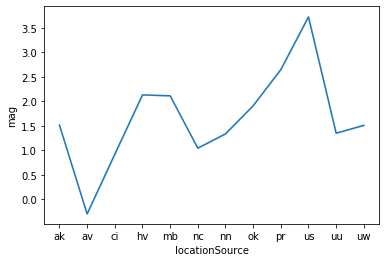

In [5]:
eq_loc = sb.lineplot(x = 'locationSource', y = 'mag', data = earthquakes, ci = False)

In [6]:
#Changes